In [1]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

In [2]:
train_df = pd.read_csv('dataset/train_01.csv')
test_df = pd.read_csv('dataset/test_01.csv')

In [3]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns='id')

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42
                                                   )


kfold = KFold(n_splits=5)

# RFC

In [5]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [6]:
train_score_rfc = rfc.score(x_train, y_train)
test_score_rfc = rfc.score(x_test, y_test)

print('train score:{}, test_score:{}'.format(train_score_rfc, test_score_rfc))

train score:0.9998945703742752, test_score:0.9265682656826568


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


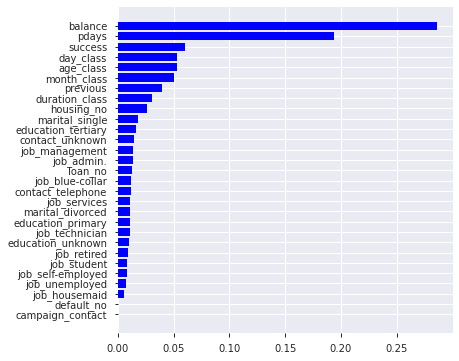

In [7]:
features = x_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

# XGB

In [8]:
xgb = xgb.XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [9]:
train_score_xgb = xgb.score(x_train, y_train)
test_score_xgb = xgb.score(x_test, y_test)

print('train score:{}, test_score:{}'.format(train_score_xgb, test_score_xgb))

train score:0.9460200316288877, test_score:0.928290282902829


# LGB

In [10]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)

params_lgb = {
    'objective': 'binary',
    'metric':'auc',
    'num_iterations':1000,
    'eary_stopping': 50,
}

lgb = lgb.train(params_lgb, lgb_train, valid_sets=lgb_eval, verbose_eval=100)

[100]	valid_0's auc: 0.788552


/home/awax2/miniconda3/envs/lab/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	valid_0's auc: 0.777474
[300]	valid_0's auc: 0.765582
[400]	valid_0's auc: 0.756273
[500]	valid_0's auc: 0.75054
[600]	valid_0's auc: 0.74409
[700]	valid_0's auc: 0.738673
[800]	valid_0's auc: 0.733091
[900]	valid_0's auc: 0.728905
[1000]	valid_0's auc: 0.725319


# CB

In [11]:
params_cab = {
    'iterations':1000,
    'custom_loss':['Accuracy'],
    'early_stopping_rounds':50,
}

In [12]:
cab = CatBoostClassifier(**params_cab)

cab.fit(x_train, y_train)

Learning rate set to 0.036197
0:	learn: 0.6525157	total: 68.9ms	remaining: 1m 8s
1:	learn: 0.6160203	total: 76.5ms	remaining: 38.2s
2:	learn: 0.5818637	total: 89ms	remaining: 29.6s
3:	learn: 0.5519246	total: 103ms	remaining: 25.7s
4:	learn: 0.5245726	total: 113ms	remaining: 22.5s
5:	learn: 0.4988407	total: 117ms	remaining: 19.4s
6:	learn: 0.4776447	total: 120ms	remaining: 17s
7:	learn: 0.4567890	total: 124ms	remaining: 15.4s
8:	learn: 0.4368565	total: 127ms	remaining: 14s
9:	learn: 0.4199733	total: 132ms	remaining: 13.1s
10:	learn: 0.4045152	total: 136ms	remaining: 12.2s
11:	learn: 0.3906240	total: 139ms	remaining: 11.4s
12:	learn: 0.3777333	total: 142ms	remaining: 10.8s
13:	learn: 0.3670284	total: 145ms	remaining: 10.2s
14:	learn: 0.3563019	total: 149ms	remaining: 9.81s
15:	learn: 0.3464260	total: 153ms	remaining: 9.4s
16:	learn: 0.3359637	total: 157ms	remaining: 9.06s
17:	learn: 0.3277747	total: 160ms	remaining: 8.74s
18:	learn: 0.3191512	total: 164ms	remaining: 8.46s
19:	learn: 0.31

In [13]:
train_score_cab = cab.score(x_train, y_train)
test_score_cab = cab.score(x_test, y_test)

print('train score:{}, test_score:{}'.format(train_score_cab, test_score_cab))

train score:0.9429625724828676, test_score:0.9293972939729397


## submit

In [14]:
pred_rfc = rfc.predict(test_df)
pred_xgb = xgb.predict(test_df)
pred_lgb = lgb.predict(test_df)
pred_cab = cab.predict(test_df)

In [15]:
pred = pd.DataFrame({
    'RandomForest': pred_rfc,
    'XGBoost': pred_xgb,
    'LigntGBM': pred_lgb,
    'CatBoost': pred_cab
})

pred['sum'] = pred.sum(axis=1)
pred['pred'] = [i / 4.0 for i in pred['sum']]
pred.head()

,RandomForest,XGBoost,LigntGBM,CatBoost,sum,pred
0,1,1,0.994443,1,3.994443,0.998611
1,0,0,0.010155,0,0.010155,0.002539
2,0,0,0.000719,0,0.000719,0.000180
3,0,0,0.002475,0,0.002475,0.000619
4,0,0,0.182288,0,0.182288,0.045572


In [17]:
submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['pred']
})


now = datetime.datetime.now()
file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)